In [2]:
import numpy as np
import scipy as sp
import scipy.constants as sc 
import scipy.fftpack as fft
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import sys,os; sys.path.insert(0, os.path.expanduser('.libraries/lib_CUWA/')); 
import lib_CUWA_core as lib_CUWA #This library contains minimal code needed to run CUWA
import gaussian_beam as GB
from tqdm.auto import tqdm

ModuleNotFoundError: No module named 'lib_CUWA_core'

In [ ]:
def delay(time : np.ndarray, sig : np.ndarray) -> float : 
    """
    delay return the time delay of the signal

    Parameters
    ----------
    time : np.ndarray
        _description_
    sig : np.ndarray
        _description_

    Returns
    -------
    float
        _description_
    """    
    return time[np.argmax(abs(sig))]

In [326]:
def delay_dispersion(time, signal) -> float: 
    """
    delay_dispersion return the dispersion of the signal given a threshold 1/e * max(signal)

    Parameters
    ----------
    time : np.ndarray
        _description_
    signal : np.ndarray
        _description_

    Returns
    -------
    float
        _description_
    """    
    mask = np.abs(signal) > np.exp(-1) * np.max(np.abs(signal))
    time_window = time[mask]
    
    return (time_window[-1] - time_window[0]) / 2 

In [327]:
def Gaussian_turb(lx : float,ly : float,nx : float, ny : int, dx : float) -> np.ndarray: 
    """
    Gaussian_turb generate a 2d Gaussian turbulence field

    Parameters
    ----------
    lx : float
        correlation length in x of turbulence
    ly : float
        correlation length in y of turbulence
    nx : float
        number of points in x
    ny : int
        number of points in y
    dx : float
        grid spacing

    Returns
    -------
    np.ndarray
        _description_
    """    
    
    kx = 2*np.pi*np.arange(-0.5/dx,0.5/dx-0.5/dx/nx,1/dx/nx)
    ky = 2*np.pi*np.arange(-0.5/dx,0.5/dx-0.5/dx/ny,1/dx/ny)
    
    expx = np.exp(-kx**2*lx**2/8)
    expy = np.exp(-ky**2*ly**2/8)
    
    spectra = np.exp(np.random.rand(nx,ny)*2j*np.pi)
    spectra = spectra*expx[:,None]*expy[None,:]
    
    fluct = fft.ifftshift(fft.ifft2(fft.ifftshift(spectra)))
    
    return fluct.real * np.pi / dx**2 * lx * ly

In [328]:
def run_CUWA(C1 : lib_CUWA.CUWA ,w_p , w_c,  b_x, b_y, b_z, beam : GB.GaussianBeam) -> None:
    
    C1.set_plasma_data(w_p, w_c, b_x, b_y, b_z) # TODO ask for the meaning of the parameters b_x, b_y, b_z
    C1.set_antenna(beam, source='True', receiver='True')
    #C1.set_antenna(beam2, source='False', receiver='True')
    C1.run_init()

    steps=round(C1.suggested_n_steps*1.7)
    reAz_list=[];imAz_list=[];t_list = [];IQ=[] #preparing list for the signal
    record=1 #recognizing the arrival of the pulse
    
    for t in tqdm(range(int(steps)), leave=False, desc='Running CUWA'):
        
        C1.run_source(t,beam)
        C1.run_phasor(t,beam)
        reAx_g,reAy_g,reAz_g,imAx_g,imAy_g,imAz_g = [field.get() for field in beam.A_g]
        C1.run_step()

        
    
        if t % (beam.T//8) == 0 and t> 1*beam.T:             
        
            if record == 1:   #recording the previous period signal
                t_list.append(t*C1.dt)
                IQ.append(np.sum(reAz_list)+1j*np.sum(imAz_list))
                #reAz_list=[]  #resetting the recording
                #imAz_list=[]
        
    
        if record==1:   #recording data for each period 
            reAz_list.append(np.trapz(reAz_g[0,0,:]))   
            imAz_list.append(np.trapz(imAz_g[0,0,:]))    
            if len(reAz_list)>beam.T:
                reAz_list.pop(0)
                imAz_list.pop(0)
    
    return t_list, IQ


In [329]:
full_id = 0

In [353]:
fs= 51
f0= 51 #probing frequency
amplitudes = np.logspace(-5,0, 50)


In [354]:
folder='./output' #output folder
if not os.path.exists(folder):
    os.makedirs(folder)

In [355]:
for amp in amplitudes:    
    fname=folder+"/a_{:.4f}".format(amp)
    if not os.path.exists(fname):
        os.makedirs(fname)

In [356]:
os.environ['PATH'] = '/usr/local/cuda/bin:/usr/local/gcc/7.2.0/bin'

In [357]:


C1 = lib_CUWA.CUWA() # Initialisation of the CUWA. When running on local GPU the GPU context is initialised 
L=0.1*f0**2/2500
lcx=0.01
lcy=0.02
teta=0*sc.pi/180
ro=0.05
w=f0*sc.pi*2*1e9



6.9 GB is free of total 7.9 GB


In [364]:

def generate_density(amp, C1) : 
    
    X,Y,Z = C1.get_fine_grid()
    ldn=0.6
    ymin=0.05
    ycut=0

    nc=w**2/sc.e**2*(sc.m_e*sc.epsilon_0)
    n0=nc*np.fmax(Y-ymin,0)/L
    n0[n0<0]=0
        
    while n0[0,ycut,0]<nc*np.cos(teta)**2:
        ycut+=1
        
    dn=Gaussian_turb(lcx,lcy,C1.Size_Y,C1.Size_X,C1.dx)
    dn=(dn-dn.mean())/ dn.std()
    
    band=np.exp( -(np.fmax(Y,0)-Y[0,ycut,0])**2 / ldn**2)
    dn=np.multiply(amp*dn*nc,band)
    dn[n0+dn<0]=0    
    dn[n0==0]=0
    
    
    
    w_p = sc.e * np.sqrt((n0 + dn) /(sc.m_e * sc.epsilon_0))
    w_p_extr2 = np.copy(w_p)
    w_p_extr2[w_p_extr2 > 0] = 1
    blure_image = gaussian_filter(w_p,10)
    blure_edge  = gaussian_filter(w_p_extr2,10)
    
    return  w_p * (blure_edge > 0.98) + blure_image * (blure_edge <= 0.98)


In [365]:

X,Y,Z = C1.set_comp_grid(omega_ref = w, 
                         vac_resolution = 24,
                         origin = np.array((0,0,0)), 
                               e_x = np.array((1,0,0)), 
                               e_y = np.array((0,1,0)), 
                               x_range = (-0.15,0.15), 
                               y_range =  (0,0.21), 
                               z_thick  =  0.0,
                               nPML=24,
                               Courant = 0.5)

w_c = sc.e / sc.m_e * 2.4 + 0. * (X)
ratio=C1.Size_X/C1.Size_Y
b_x = b_y = np.zeros_like(X)
b_z = np.ones_like(X)

In [366]:
dt=C1.dt
Cour=C1.Courant
steps=C1.suggested_n_steps

In [367]:
Tfix=np.ceil(1/fs/1e9/dt)
C1.Courant=f0/fs*C1.n_steps_per_lambda/Tfix
C1.dt=dt*C1.Courant/Cour
C1.suggested_n_steps=steps*Cour/C1.Courant

beam = GB.GaussianBeam(frequency_GHz = fs,
                                 mode          = 'O',
                                 origin        = np.array((0.0,0,0)),
                                 gaussian_focus= np.array((0.003*np.tan(teta),0.003,0)),
                                 waist_radius  = ro,
                                 pulse = 0.9) #ns  
t_list0, IQ0 = run_CUWA(C1,generate_density(0, C1)*0, w_c, b_x, b_y, b_z, beam)  

for amp in tqdm(amplitudes, desc='amplitudes loop', leave=False): 

   
    #print('courant is '+str(C1.Courant)+', dt is '+str(C1.dt)+', steps= '+str(C1.suggested_n_steps) +', period is ' + str(1/fs/C1.dt/1e9) )
    
    beam = GB.GaussianBeam(frequency_GHz = fs,
                                 mode          = 'O',
                                 origin        = np.array((0.0,0,0)),
                                 gaussian_focus= np.array((0.003*np.tan(teta),0.003,0)),
                                 waist_radius  = ro,
                                 pulse = 0.9) #ns    
    
    if full_id==0:
        
        folname=folder+'/a_{:.4f}/'.format(amp)
        np.save(folder+"/a_{:.4f}/time.npy".format(amp),t_list0)
        np.save(folder+"/a_{:.4f}/IQ0.npy".format(amp),IQ0)


    
    band=np.exp( -(np.fmax(Y,0)-Y[0,ycut,0])**2 / ldn**2)
    dn=np.multiply(amp*dn0*nc,band)
    dn[n0+dn<0]=0    
    dn[n0==0]=0

    w_p = sc.e * np.sqrt((n0+dn) /(sc.m_e * sc.epsilon_0))
    w_p_extr2 = np.copy(w_p)
    w_p_extr2[w_p_extr2 > 0] = 1
    blure_image = gaussian_filter(w_p,10)
    blure_edge  = gaussian_filter(w_p_extr2,10)
    w_p = w_p * (blure_edge > 0.98) + blure_image * (blure_edge <= 0.98)
    
    np.save(folder+"/a_{:.4f}/w_p.npy".format(amp),w_p)
    t_list, IQ = run_CUWA(C1,w_p, w_c, b_x, b_y, b_z, beam)
    
    IQ = np.array(IQ)-np.array(IQ0)      
    np.save(folder+"/a_{:.4f}/IQ_{:04d}.npy".format(amp,full_id),IQ)
    
    E = C1.get_magE()
    np.save(folder+"/a_{:.4f}/E_{:04d}.npy".format(amp,full_id),E)


UnboundLocalError: local variable 'dn0' referenced before assignment

In [348]:
IQ_list = []
time_list = []
wp_list = []
amplitudes = []
E_list = []
for i , file in enumerate(os.listdir('./output')) :
    if file[0] == 'a' : 
        amplitudes.append(float(file[2:]))
        IQ_list.append(np.load('./output/'+file+'/IQ_0000.npy'))
        time_list.append(np.load('./output/'+file+'/time.npy'))
        wp_list.append(np.load('./output/'+file+'/w_p.npy'))
        E_list.append(np.load('./output/'+file+'/E_0000.npy'))
        

FileNotFoundError: [Errno 2] No such file or directory: './output'

/usr/lib64/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


IndexError: list index out of range

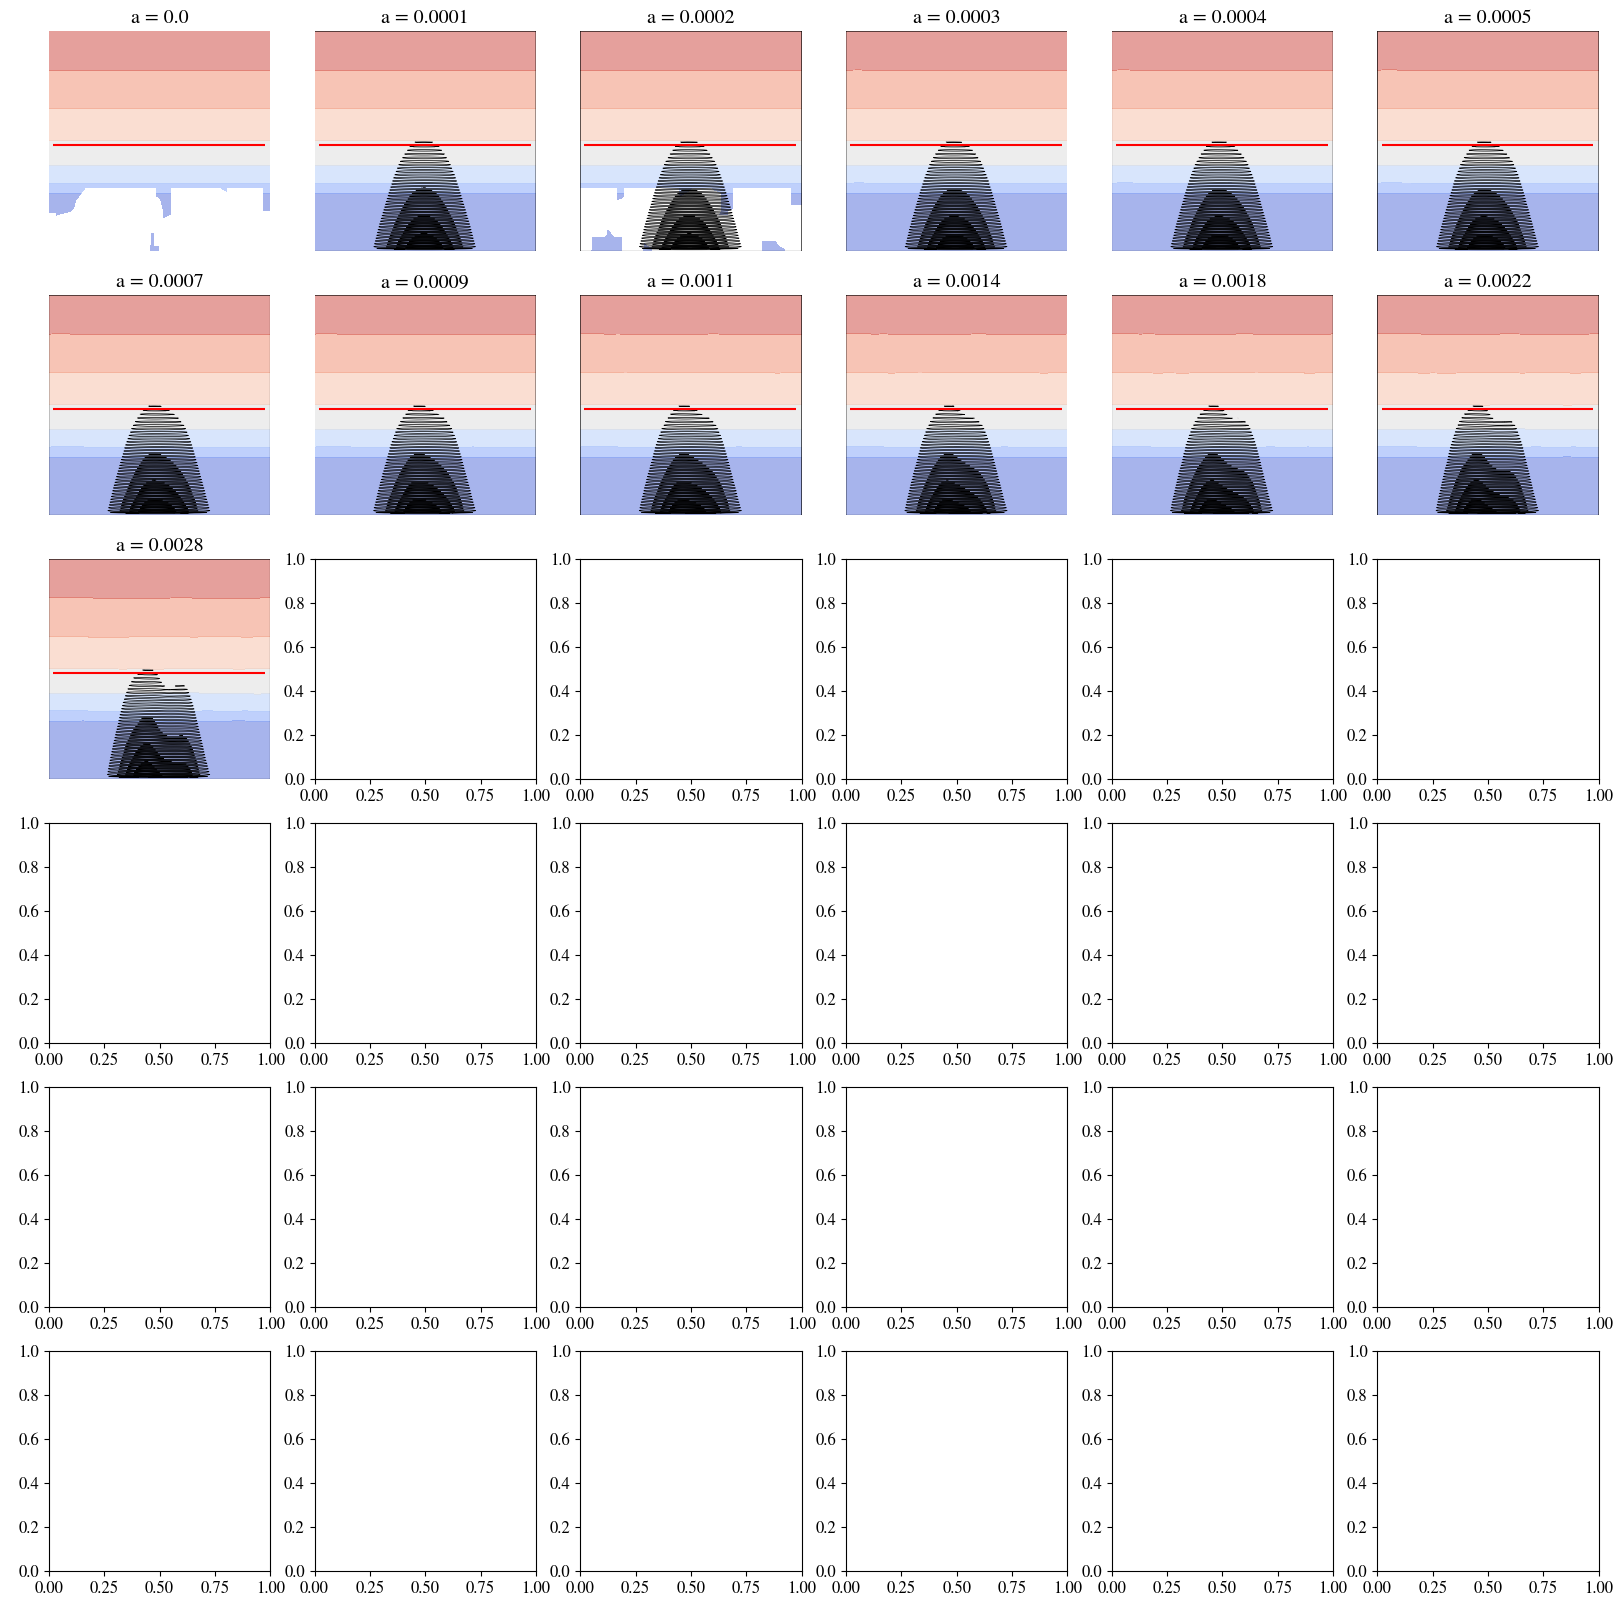

In [346]:
fig, ax = plt.subplots(int(np.sqrt(len(IQ_list))),int(np.sqrt(len(IQ_list))), figsize=(20,20))
grid = C1.get_fine_grid()
for i, ax in enumerate(ax.flatten()): 
    ax.contourf(grid[0][0], grid[1][0], wp_list[np.argsort(amplitudes)[i]][0], cmap = 'coolwarm', alpha = 0.5)
    ax.contour(grid[0][0], grid[1][0],E_list[np.argsort(amplitudes)[i]][0], colors = 'k', linewidths = 0.5, levels = 4)
    ax.set_title('a = '+str(amplitudes[np.argsort(amplitudes)[i]]))
    ax.hlines(L, -0.15, 0.15, color = 'r')
    ax.set_axis_off()


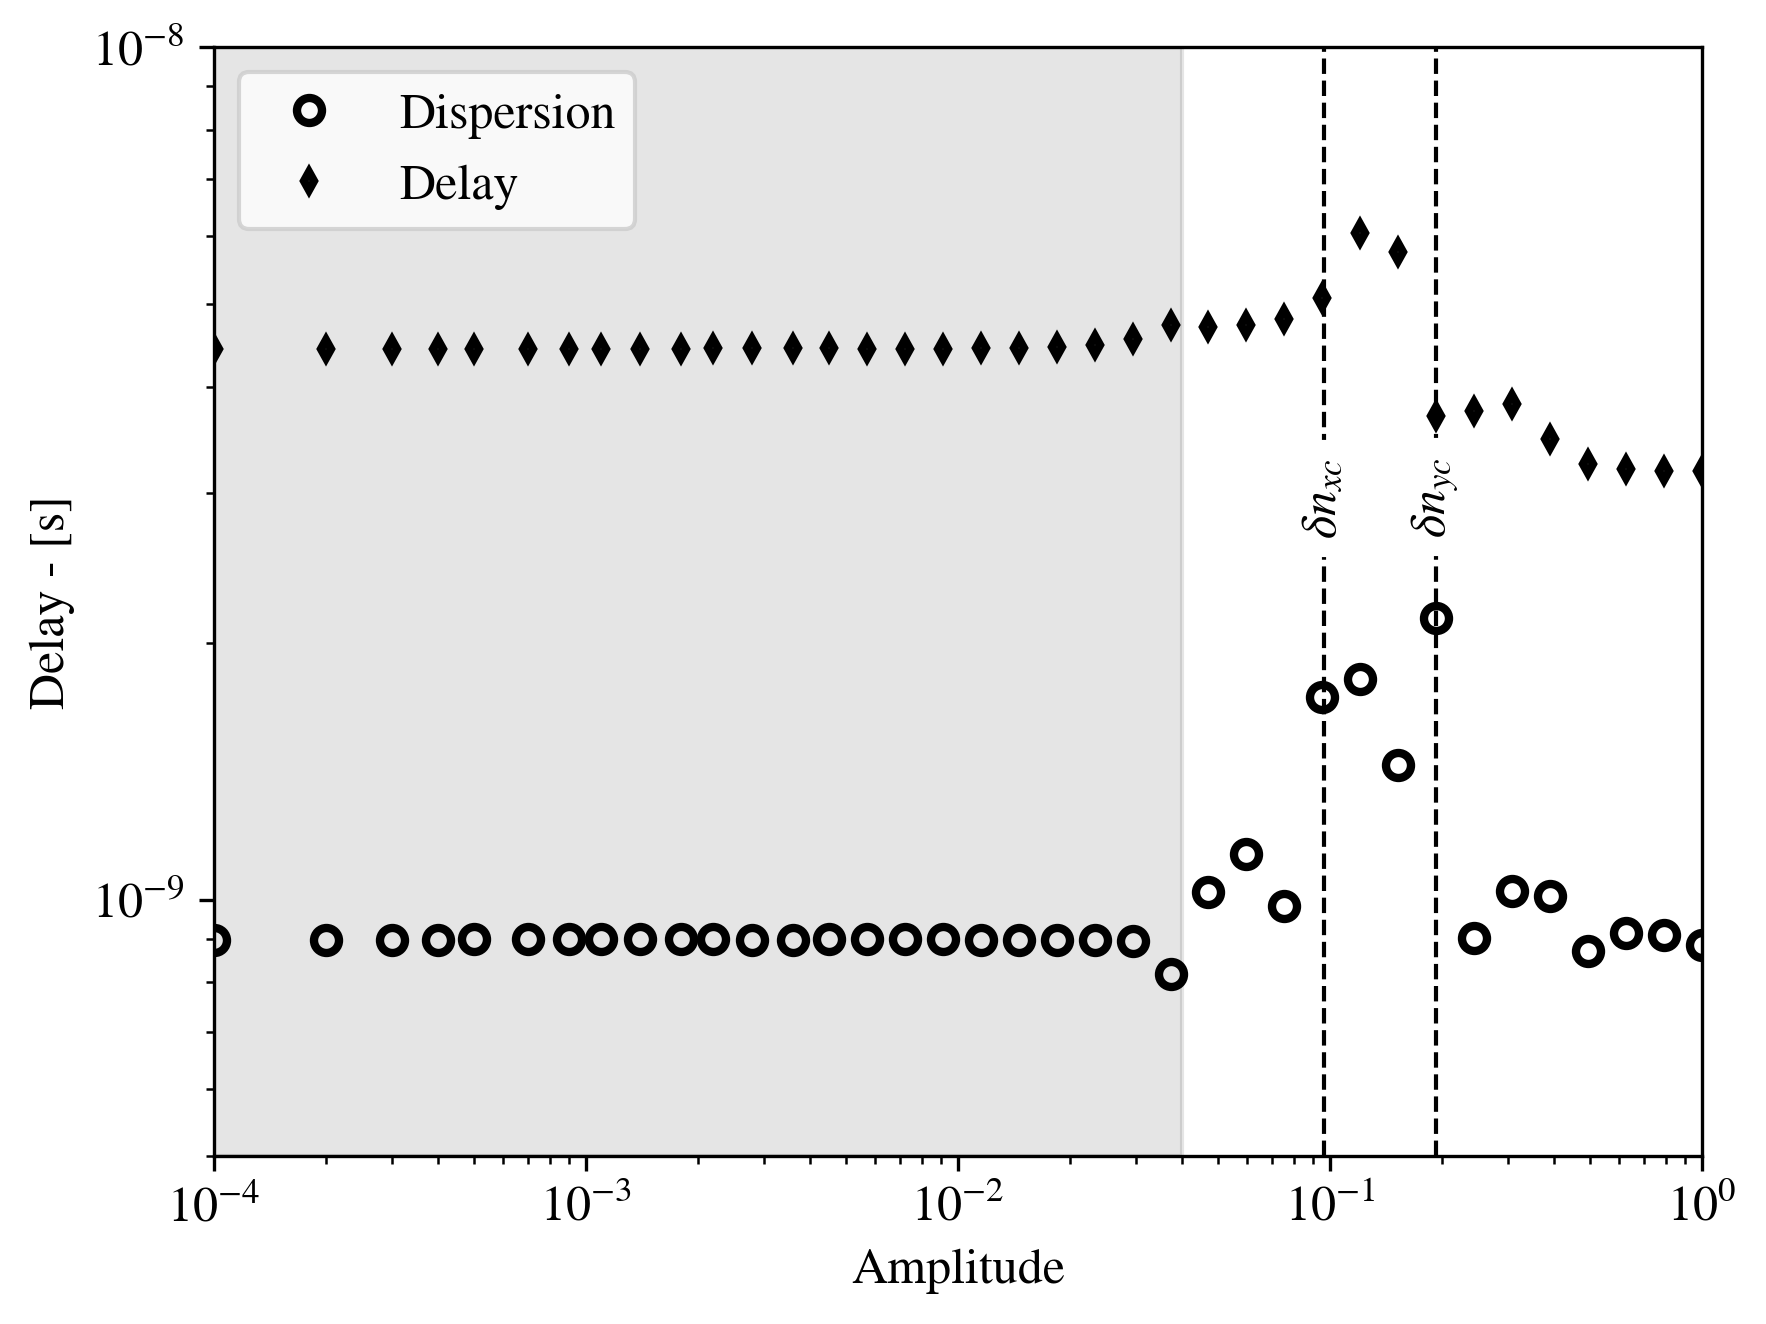

In [323]:
rc = {"font.family" : "STIXGeneral", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)

fig, ax = plt.subplots(dpi = 300)
ax.plot(amplitudes, [delay_dispersion(time, IQ) for time, IQ in zip(time_list, IQ_list)], lw = 0, marker = 'o', ms = 6, mfc= 'none', mec = 'k', mew = 2, label = 'Dispersion')
ax.plot(amplitudes, [delay(time, IQ) for time, IQ in zip(time_list, IQ_list)], lw = 0, marker = 'd', ms = 3, mfc= 'none', mec = 'k', mew = 2, label = 'Delay')
ax.axvline(lcy / L,  ls = '--', color = 'k', lw = 1)
ax.axvline(lcx / L,  ls = '--', color = 'k', lw = 1)
ax.text(lcx / L, 3e-9, '$\\delta n_{xc}$', fontsize = 12, ha = 'center', backgroundcolor = 'w', rotation = 90 )
ax.text(lcy / L, 3e-9, '$\\delta n_{yc}$', fontsize = 12, ha = 'center', backgroundcolor = 'w', rotation = 90)
ax.axvspan(1e-5, 0.04, alpha = 0.1, color = 'k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Amplitude')
ax.set_ylabel('Delay - [s]')
ax.set_ylim(5e-10, 1e-8)
ax.set_xlim(1e-4, 1)
ax.legend()

In [ ]:
#TODO Generate many density fluctuations and mean the results

In [263]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))